# integrate spatial transcriptomics and scRNA-seq data 
https://scanpy-tutorials.readthedocs.io/en/latest/spatial/integration-scanorama.html

In [2]:
import scanpy as sc 
# import scanpy.anndata as an 
import pandas as pd 
import numpy as np 
import matplotlib.pyplot as plt 
import seaborn as sns 
import scanorama 

In [3]:
sc.logging.print_versions()
sc.set_figure_params(facecolor="white", figsize=(8, 8))
sc.settings.verbosity = 3

The `sinfo` package has changed name and is now called `session_info` to become more discoverable and self-explanatory. The `sinfo` PyPI package will be kept around to avoid breaking old installs and you can downgrade to 0.3.2 if you want to use it without seeing this message. For the latest features and bug fixes, please install `session_info` instead. The usage and defaults also changed slightly, so please review the latest README at https://gitlab.com/joelostblom/session_info.
-----
anndata     0.8.0
scanpy      1.8.2
sinfo       0.3.4
-----
PIL                 8.4.0
annoy               NA
apport_python_hook  NA
asttokens           NA
backcall            0.2.0
beta_ufunc          NA
binom_ufunc         NA
cairo               1.16.2
colorama            0.4.3
cycler              0.10.0
cython_runtime      NA
dateutil            2.8.2
debugpy             1.6.0
decorator           5.1.0
entrypoints         0.3
executing           0.8.3
fbpca               NA
google              NA
h5py 

# reading the data

In [4]:
adata_spatial_anterior = sc.datasets.visium_sge(
    sample_id="V1_Mouse_Brain_Sagittal_Anterior"
)
adata_spatial_posterior = sc.datasets.visium_sge(
    sample_id="V1_Mouse_Brain_Sagittal_Posterior"
)

100%|██████████| 8.81M/8.81M [00:01<00:00, 8.76MB/s]
100%|██████████| 19.6M/19.6M [00:02<00:00, 9.32MB/s]

reading /mnt/c/Users/han13/OneDrive/Documents/MPhil ACS/L45 Representation Learning on Graphs and Networks/project/code/data/V1_Mouse_Brain_Sagittal_Anterior/filtered_feature_bc_matrix.h5


 (0:00:00)


/home/hbl/.local/lib/python3.8/site-packages/anndata/_core/anndata.py:1830: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.
  utils.warn_names_duplicates("var")
100%|██████████| 9.26M/9.26M [00:01<00:00, 8.00MB/s]
100%|██████████| 20.1M/20.1M [00:02<00:00, 9.31MB/s]

reading /mnt/c/Users/han13/OneDrive/Documents/MPhil ACS/L45 Representation Learning on Graphs and Networks/project/code/data/V1_Mouse_Brain_Sagittal_Posterior/filtered_feature_bc_matrix.h5


 (0:00:00)


In [5]:
adata_spatial_anterior.var_names_make_unique()
adata_spatial_posterior.var_names_make_unique()
sc.pp.calculate_qc_metrics(adata_spatial_anterior, inplace=True)
sc.pp.calculate_qc_metrics(adata_spatial_posterior, inplace=True)

/home/hbl/.local/lib/python3.8/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


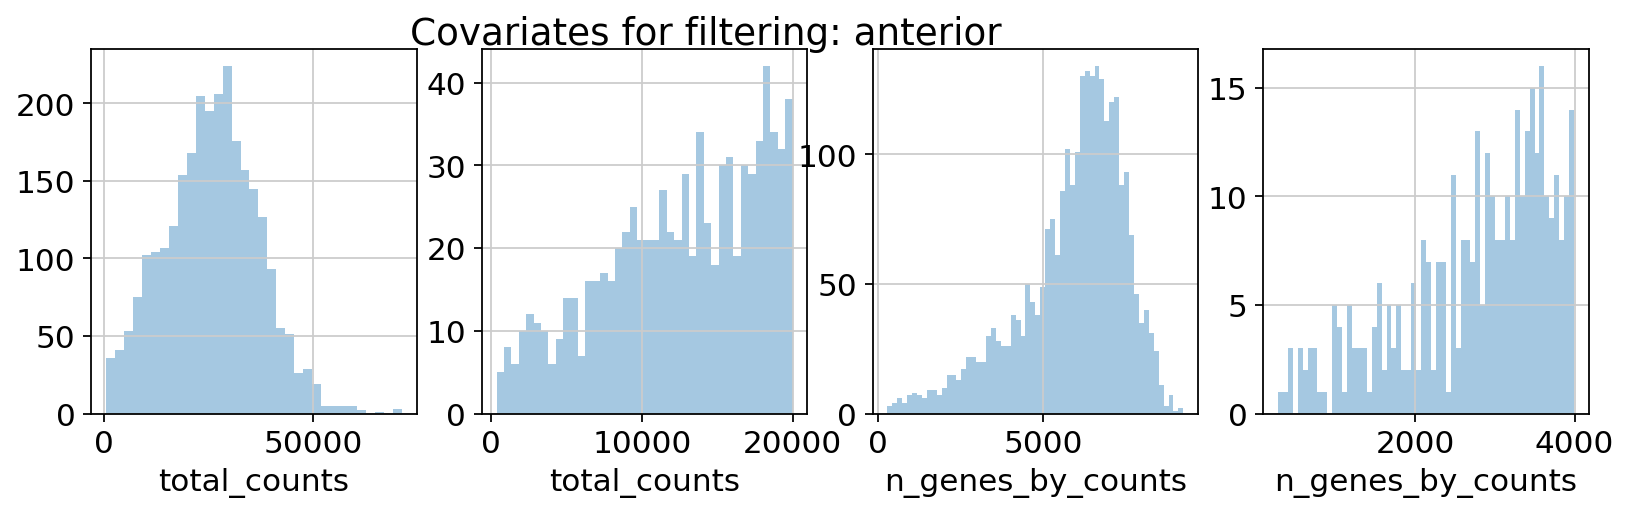

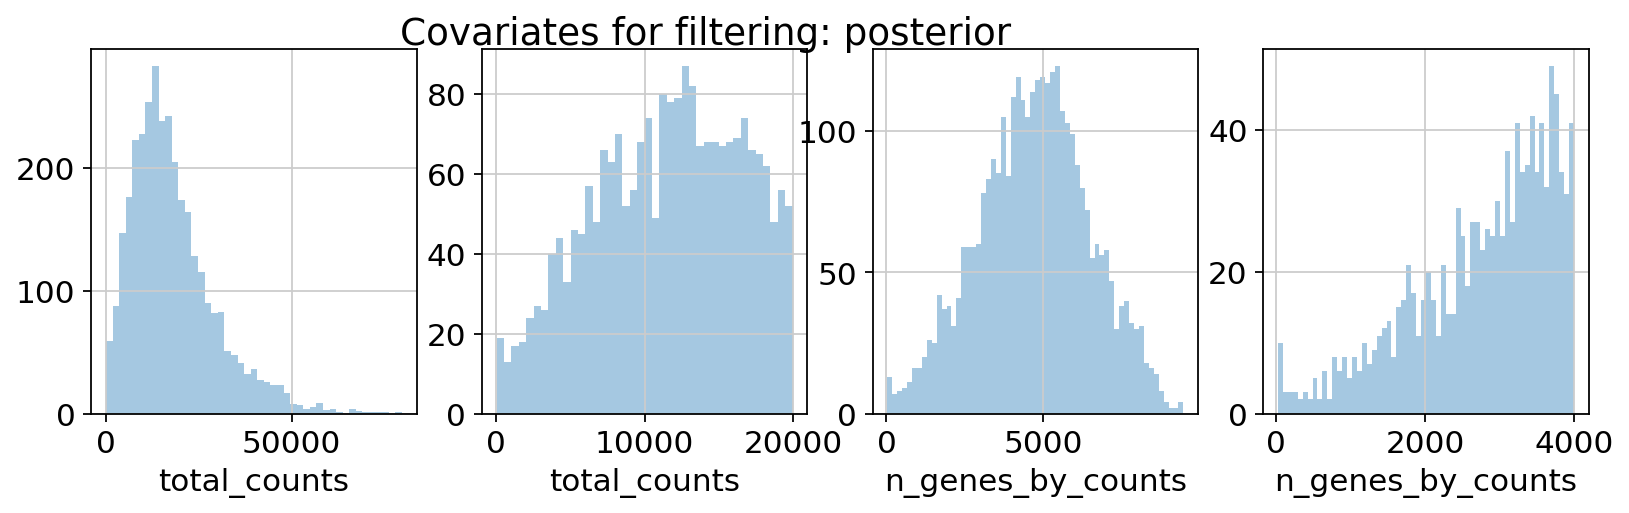

In [6]:
for name, adata in [
    ("anterior", adata_spatial_anterior),
    ("posterior", adata_spatial_posterior),
]:
    fig, axs = plt.subplots(1, 4, figsize=(12, 3))
    fig.suptitle(f"Covariates for filtering: {name}")

    sns.distplot(adata.obs["total_counts"], kde=False, ax=axs[0])
    sns.distplot(
        adata.obs["total_counts"][adata.obs["total_counts"] < 20000],
        kde=False,
        bins=40,
        ax=axs[1],
    )
    sns.distplot(adata.obs["n_genes_by_counts"], kde=False, bins=60, ax=axs[2])
    sns.distplot(
        adata.obs["n_genes_by_counts"][adata.obs["n_genes_by_counts"] < 4000],
        kde=False,
        bins=60,
        ax=axs[3],
    )

In [7]:
for adata in [
    adata_spatial_anterior,
    adata_spatial_posterior,
]:
    sc.pp.normalize_total(adata, inplace=True)
    sc.pp.log1p(adata)
    sc.pp.highly_variable_genes(adata, flavor="seurat", n_top_genes=2000, inplace=True)

normalizing counts per cell
    finished (0:00:00)
If you pass `n_top_genes`, all cutoffs are ignored.
extracting highly variable genes
    finished (0:00:01)
--> added
    'highly_variable', boolean vector (adata.var)
    'means', float vector (adata.var)
    'dispersions', float vector (adata.var)
    'dispersions_norm', float vector (adata.var)
normalizing counts per cell
    finished (0:00:00)
If you pass `n_top_genes`, all cutoffs are ignored.
extracting highly variable genes
    finished (0:00:01)
--> added
    'highly_variable', boolean vector (adata.var)
    'means', float vector (adata.var)
    'dispersions', float vector (adata.var)
    'dispersions_norm', float vector (adata.var)


# data integration

In [8]:
adatas = [adata_spatial_anterior, adata_spatial_posterior]
adatas_cor = scanorama.correct_scanpy(adatas, return_dimred=True)

Found 32285 genes among all datasets
[[0.         0.49508197]
 [0.         0.        ]]
Processing datasets (0, 1)


/home/hbl/.local/lib/python3.8/site-packages/scanorama/scanorama.py:237: FutureWarning: X.dtype being converted to np.float32 from float64. In the next version of anndata (0.9) conversion will not be automatic. Pass dtype explicitly to avoid this warning. Pass `AnnData(X, dtype=X.dtype, ...)` to get the future behavour.
  adata = AnnData(datasets[i])


In [9]:
adata_spatial = sc.concat(
    adatas_cor,
    label="library_id",
    uns_merge="unique",
    keys=[
        k
        for d in [
            adatas_cor[0].uns["spatial"],
            adatas_cor[1].uns["spatial"],
        ]
        for k, v in d.items()
    ],
    index_unique="-",
)

In [10]:
sc.pp.neighbors(adata_spatial, use_rep="X_scanorama")
sc.tl.umap(adata_spatial)
sc.tl.leiden(adata_spatial, key_added="clusters")

computing neighbors
    finished: added to `.uns['neighbors']`
    `.obsp['distances']`, distances for each pair of neighbors
    `.obsp['connectivities']`, weighted adjacency matrix (0:00:08)
computing UMAP
    finished: added
    'X_umap', UMAP coordinates (adata.obsm) (0:00:09)
running Leiden clustering
    finished: found 23 clusters and added
    'clusters', the cluster labels (adata.obs, categorical) (0:00:00)


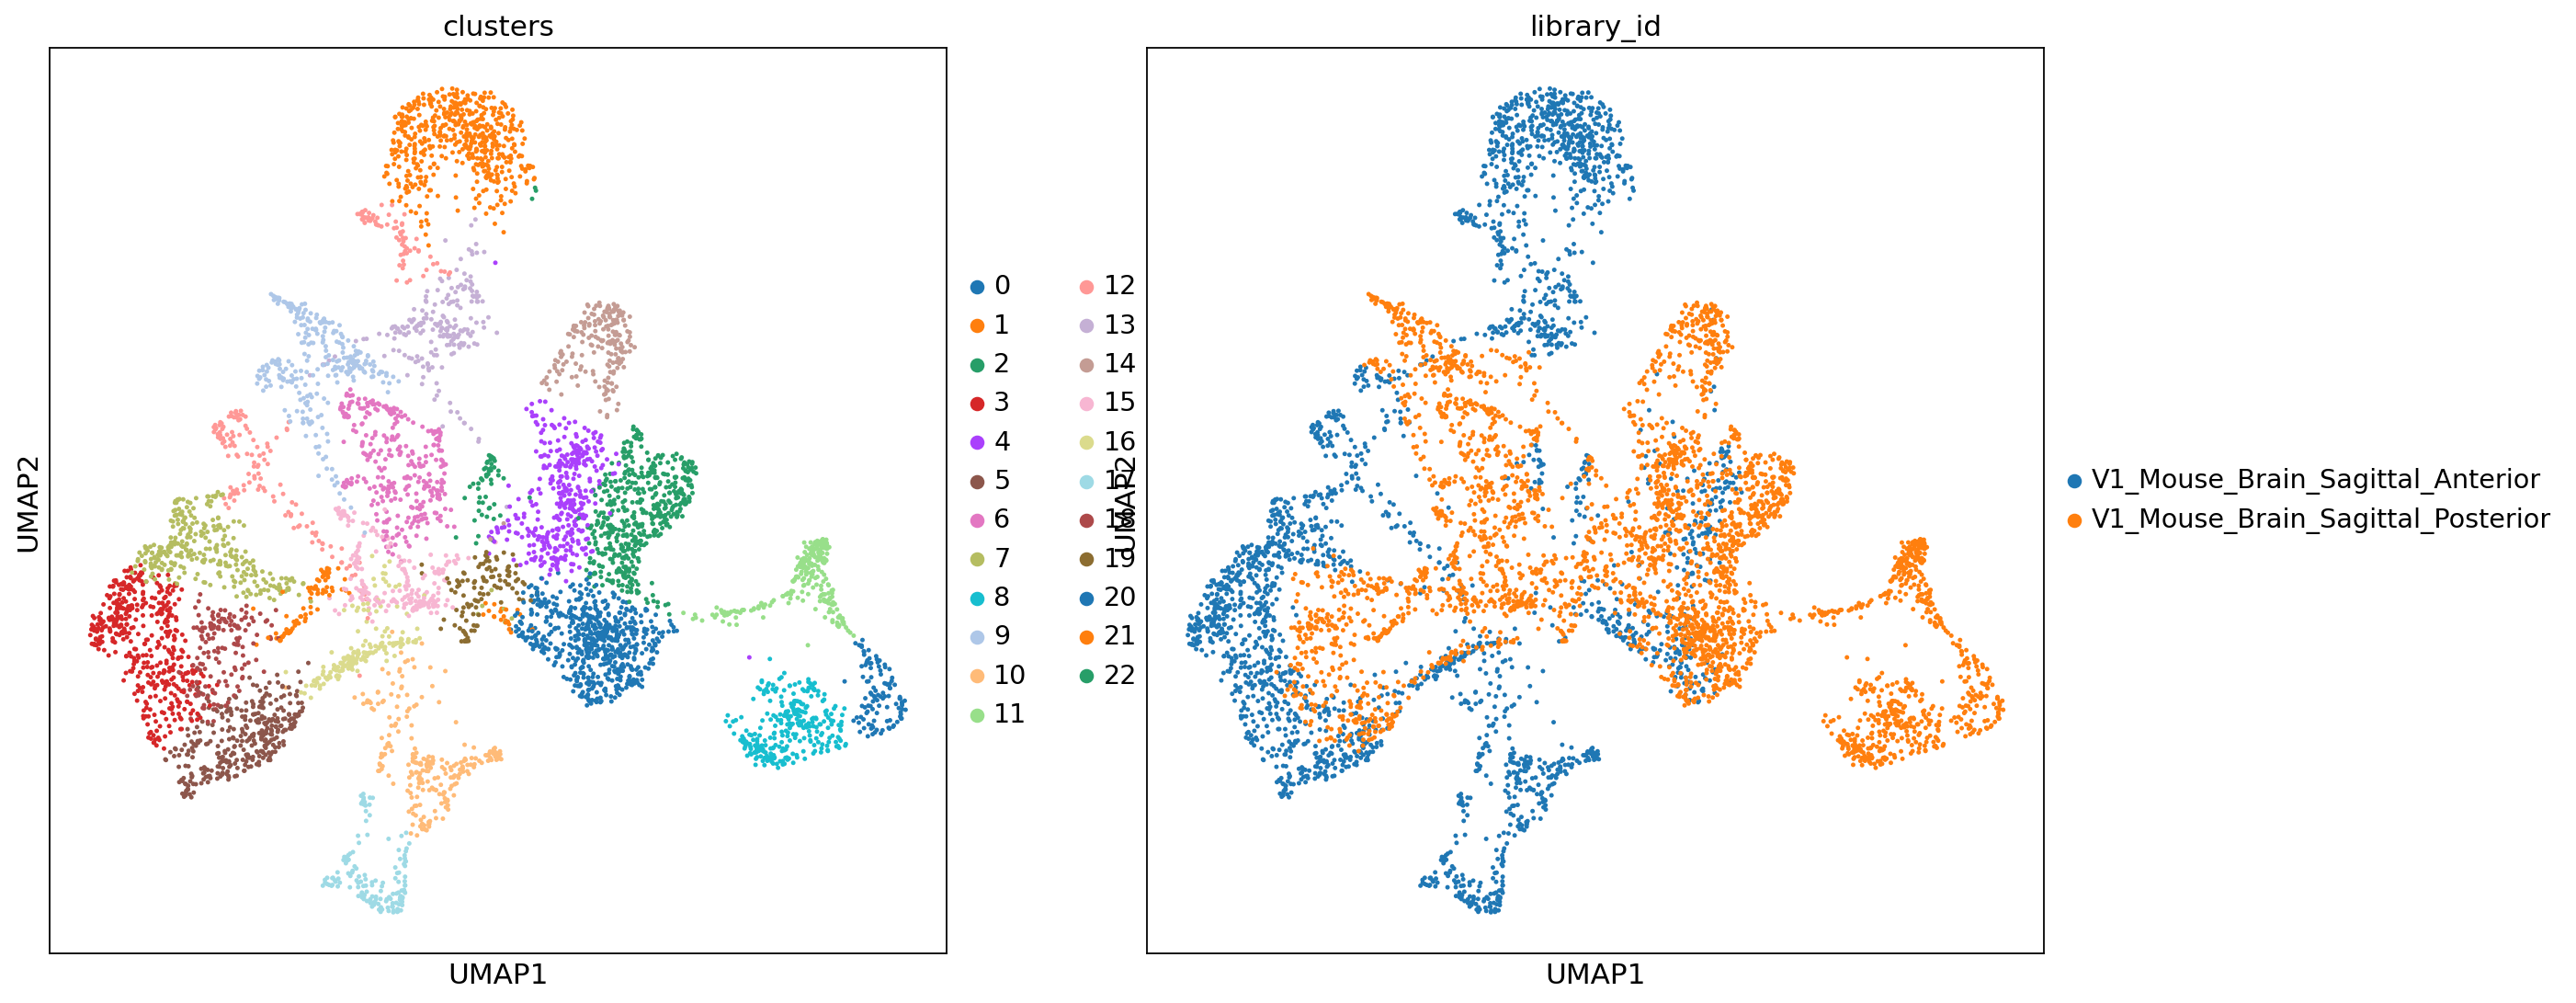

In [11]:
sc.pl.umap(
    adata_spatial, color=["clusters", "library_id"], palette=sc.pl.palettes.default_20
)

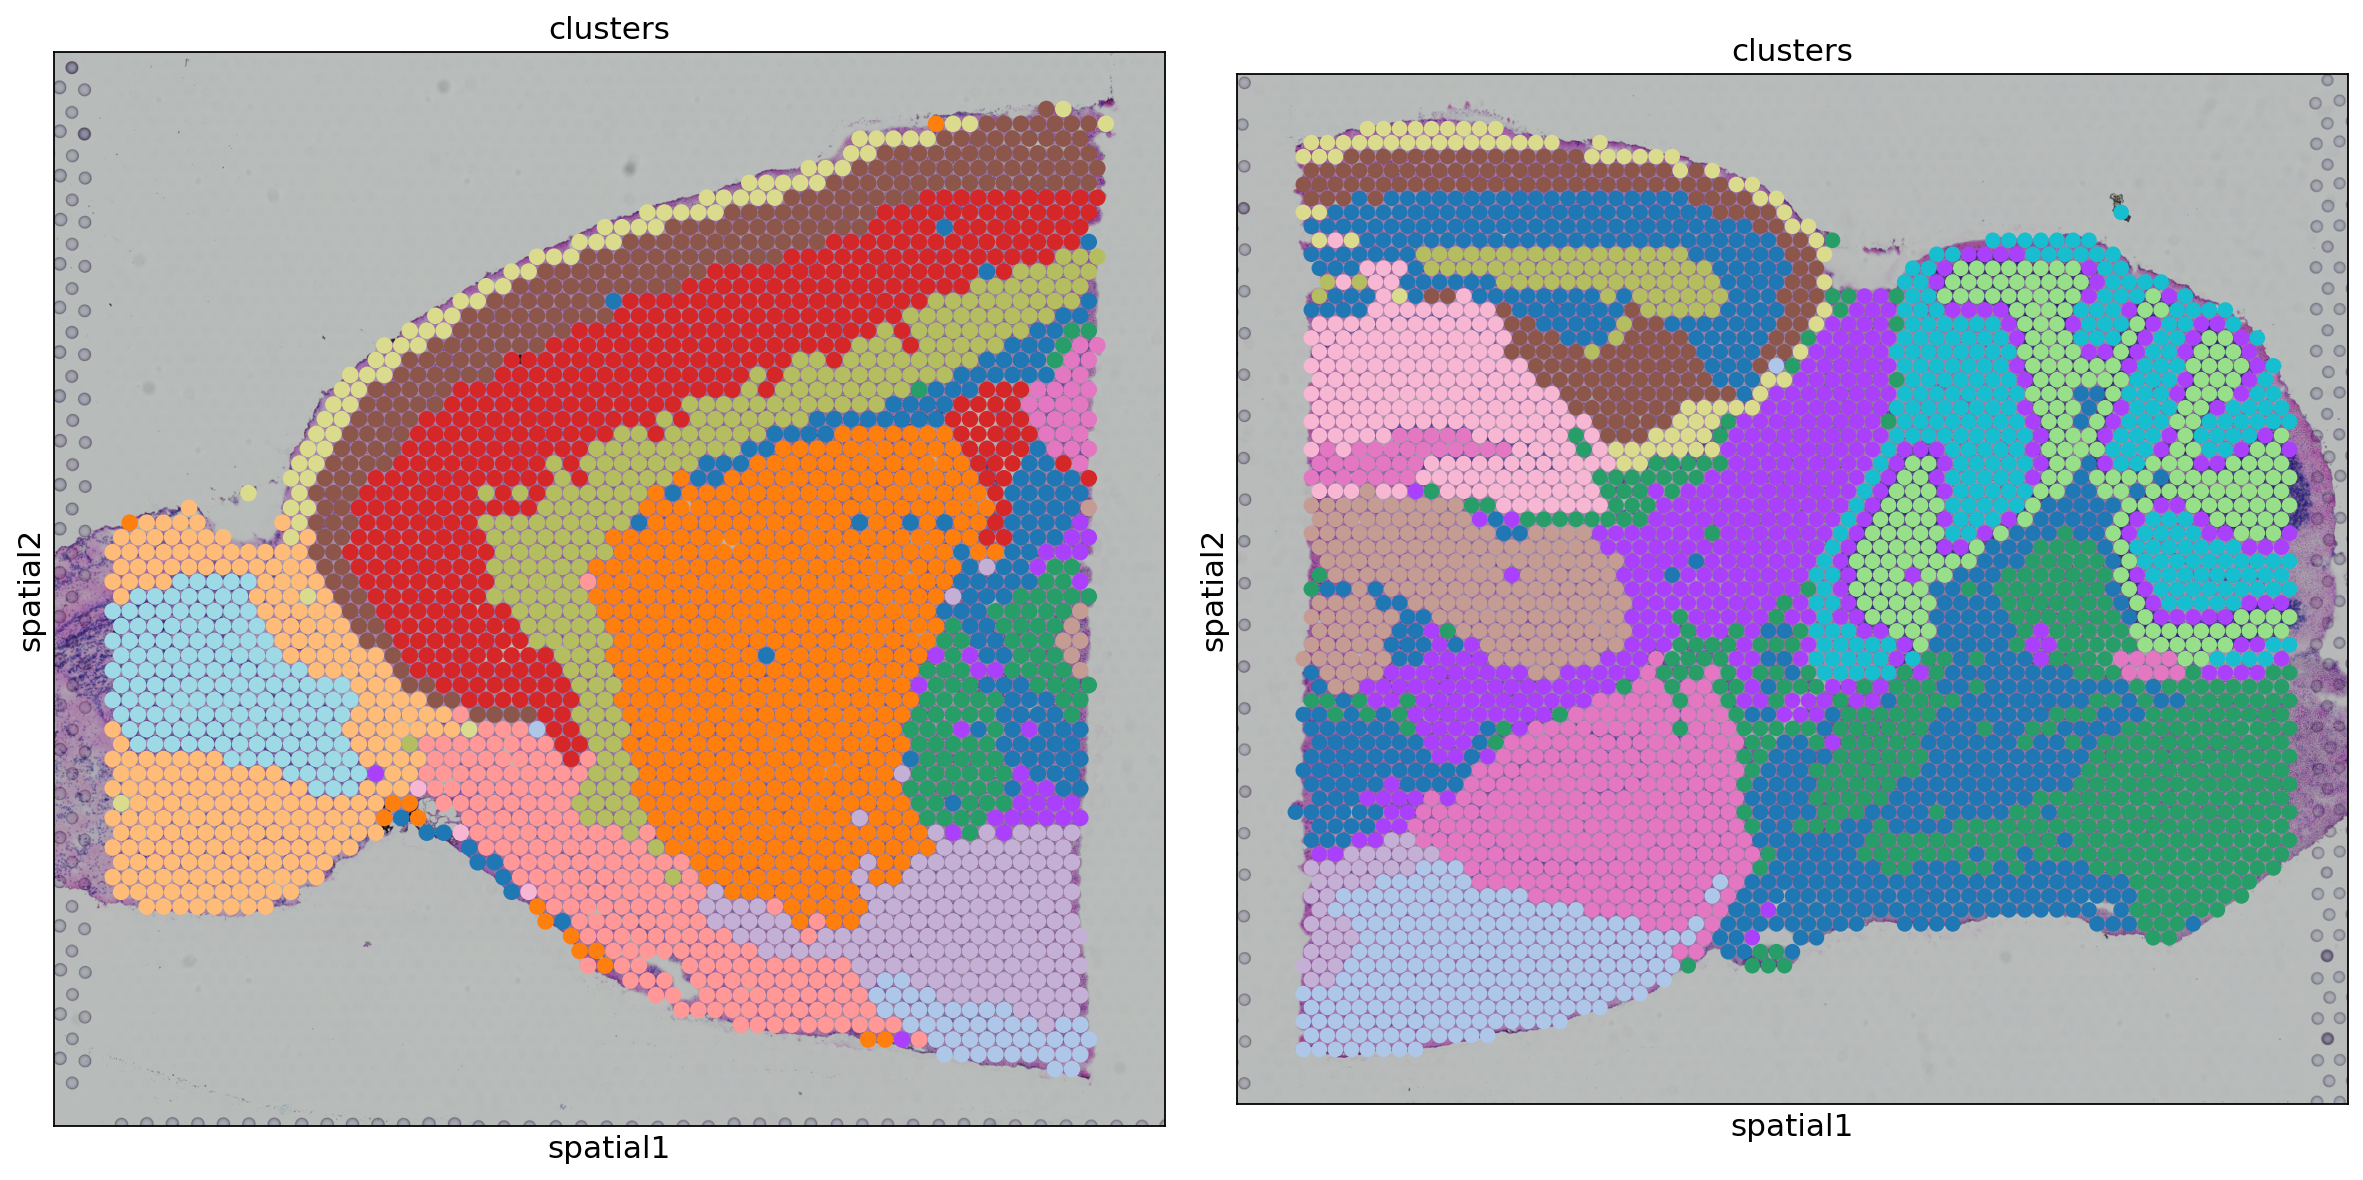

In [12]:
clusters_colors = dict(
    zip([str(i) for i in range(18)], adata_spatial.uns["clusters_colors"])
)

fig, axs = plt.subplots(1, 2, figsize=(15, 10))

for i, library in enumerate(
    ["V1_Mouse_Brain_Sagittal_Anterior", "V1_Mouse_Brain_Sagittal_Posterior"]
):
    ad = adata_spatial[adata_spatial.obs.library_id == library, :].copy()
    sc.pl.spatial(
        ad,
        img_key="hires",
        library_id=library,
        color="clusters",
        size=1.5,
        palette=[
            v
            for k, v in clusters_colors.items()
            if k in ad.obs.clusters.unique().tolist()
        ],
        legend_loc=None,
        show=False,
        ax=axs[i],
    )

plt.tight_layout()

# Data integration and label transfer from scRNA-seq dataset

In [13]:
adata_cortex = sc.read("../data/adata_processed_sc.h5ad")

/home/hbl/.local/lib/python3.8/site-packages/anndata/compat/__init__.py:232: FutureWarning: Moving element from .uns['neighbors']['distances'] to .obsp['distances'].

This is where adjacency matrices should go now.
  warn(
/home/hbl/.local/lib/python3.8/site-packages/anndata/compat/__init__.py:232: FutureWarning: Moving element from .uns['neighbors']['connectivities'] to .obsp['connectivities'].

This is where adjacency matrices should go now.
  warn(


In [14]:
adata_anterior_subset = adata_spatial_anterior[
    adata_spatial_anterior.obsm["spatial"][:, 1] < 6000, :
]
adata_posterior_subset = adata_spatial_posterior[
    (adata_spatial_posterior.obsm["spatial"][:, 1] < 4000)
    & (adata_spatial_posterior.obsm["spatial"][:, 0] < 6000),
    :,
]

In [ ]:
adatas_anterior = [adata_cortex, adata_anterior_subset]
adatas_posterior = [adata_cortex, adata_posterior_subset]


# Integration.
adatas_cor_anterior = scanorama.correct_scanpy(adatas_anterior, return_dimred=True)
adatas_cor_posterior = scanorama.correct_scanpy(adatas_posterior, return_dimred=True)

In [15]:
adata_cortex_anterior = sc.concat(
    adatas_cor_anterior,
    label="dataset",
    keys=["smart-seq", "visium"],
    join="outer",
    uns_merge="first",
)
adata_cortex_posterior = sc.concat(
    adatas_cor_posterior,
    label="dataset",
    keys=["smart-seq", "visium"],
    join="outer",
    uns_merge="first",
)

Error: Canceled future for execute_request message before replies were done

In [ ]:
from sklearn.metrics.pairwise import cosine_distances

distances_anterior = 1 - cosine_distances(
    adata_cortex_anterior[adata_cortex_anterior.obs.dataset == "smart-seq"].obsm[
        "X_scanorama"
    ],
    adata_cortex_anterior[adata_cortex_anterior.obs.dataset == "visium"].obsm[
        "X_scanorama"
    ],
)
distances_posterior = 1 - cosine_distances(
    adata_cortex_posterior[adata_cortex_posterior.obs.dataset == "smart-seq"].obsm[
        "X_scanorama"
    ],
    adata_cortex_posterior[adata_cortex_posterior.obs.dataset == "visium"].obsm[
        "X_scanorama"
    ],
)

In [ ]:
def label_transfer(dist, labels):
    lab = pd.get_dummies(labels).to_numpy().T
    class_prob = lab @ dist
    norm = np.linalg.norm(class_prob, 2, axis=0)
    class_prob = class_prob / norm
    class_prob = (class_prob.T - class_prob.min(1)) / class_prob.ptp(1)
    return class_prob

In [ ]:
class_prob_anterior = label_transfer(distances_anterior, adata_cortex.obs.cell_subclass)
class_prob_posterior = label_transfer(
    distances_posterior, adata_cortex.obs.cell_subclass
)

In [ ]:
cp_anterior_df = pd.DataFrame(
    class_prob_anterior, columns=np.sort(adata_cortex.obs.cell_subclass.unique())
)
cp_posterior_df = pd.DataFrame(
    class_prob_posterior, columns=np.sort(adata_cortex.obs.cell_subclass.unique())
)

cp_anterior_df.index = adata_anterior_subset.obs.index
cp_posterior_df.index = adata_posterior_subset.obs.index

In [ ]:
adata_anterior_subset_transfer = adata_anterior_subset.copy()
adata_anterior_subset_transfer.obs = pd.concat(
    [adata_anterior_subset.obs, cp_anterior_df], axis=1
)

adata_posterior_subset_transfer = adata_posterior_subset.copy()
adata_posterior_subset_transfer.obs = pd.concat(
    [adata_posterior_subset.obs, cp_posterior_df], axis=1
)

In [ ]:
sc.pl.spatial(
    adata_anterior_subset_transfer,
    img_key="hires",
    color=["L2/3 IT", "L4", "L5 PT", "L6 CT"],
    size=1.5,
)
sc.pl.spatial(
    adata_posterior_subset_transfer,
    img_key="hires",
    color=["L2/3 IT", "L4", "L5 PT", "L6 CT"],
    size=1.5,
)

In [ ]:
sc.pl.spatial(
    adata_anterior_subset_transfer, img_key="hires", color=["Oligo", "Astro"], size=1.5
)
sc.pl.spatial(
    adata_posterior_subset_transfer, img_key="hires", color=["Oligo", "Astro"], size=1.5
)